## Translating French into English

- 1. Data <- `x = french,y = english sentences`
- 2. Architecture
- 3. Suitable loss function

### Data

Need a parallel corpus, we need pairs of french tuples vs. english tuples. Anything that goes through the UN has many translations. But for french, any canadian website has a french and english versions. So from scrubbing those websites we have a large set of data.

#### For bounding boxes, all the interesting stuff was in the loss function, for neural translation, all the interesting stuff will be in the architecture

### Download the Fr model for spacy

In [1]:
!python -m spacy download fr

    100% |████████████████████████████████| 39.8MB 24.3MB/s ta 0:00:01

    Linking successful
    /home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fr_core_news_sm
    -->
    /home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/spacy/data/fr

    You can now load the model via spacy.load('fr')



### Download the Data (2.4 GB) / Setup the directory
~ 30 mins to download at 1MB/sec

In [5]:
!wget http://www.statmt.org/wmt10/training-giga-fren.tar

--2018-05-15 00:49:07--  http://www.statmt.org/wmt10/training-giga-fren.tar
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2595102720 (2.4G) [application/x-tar]
Saving to: ‘training-giga-fren.tar’

training-giga-fren. 100%[===================>]   2.42G   149KB/s    in 47m 17s 

2018-05-15 01:36:24 (893 KB/s) - ‘training-giga-fren.tar’ saved [2595102720/2595102720]



In [10]:
!mkdir data/translate

In [11]:
!mkdir data/translate/tmp

In [12]:
!mv training-giga-fren.tar data/translate

In [16]:
!tar -xf data/translate/training-giga-fren.tar -C data/translate/

In [24]:
!gunzip data/translate/giga-fren.release2.fixed.en.gz
!gunzip data/translate/giga-fren.release2.fixed.fr.gz

In [25]:
!ls data/translate/

giga-fren.release2.fixed.en  tmp
giga-fren.release2.fixed.fr  training-giga-fren.tar


## Import the libraries

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from fastai.text import *

In [3]:
PATH = Path('data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

### Training a Neural Model takes a long time

- Google's model has 8 layers
- we are going to build a simpler one 
- Instead of a general model we will translate French questions

### Tokenizing and Preprocessing

In [4]:
# Question regex search filters
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

# grabbling lines from the english and french source texts
lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

# isolate the questions
qs = [(e.group(), f.group()) for e,f in lines if e and f]

# save the questions for later
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [5]:
# load in pickled questions
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))
qs[:5], len(qs)

([('What is light ?', 'Qu’est-ce que la lumière?'),
  ('Who are we?', 'Où sommes-nous?'),
  ('Where did we come from?', "D'où venons-nous?"),
  ('What would we do without it?', 'Que ferions-nous sans elle ?'),
  ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
   'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')],
 52331)

#### Note that tokenizing for french is much different compared to english

In [6]:
# tokenize all the questions
en_qs,fr_qs = zip(*qs)
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')
en_tok[0], fr_tok[0]

(['what', 'is', 'light', '?'],
 ['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'])

In [7]:
# we are keeping tokens that are less than 30 chars
# The filter is applied on the english words, and the same tokens are kept for french
keep = np.array([len(o)<30 for o in en_tok])
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

# save our work
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [8]:
def toks2ids(tok,pre):
    """
    Swaps out tokens for their index representations
    """
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    
    # beginning of stream 
    itos.insert(0, '_bos_')
    
    # padding 
    itos.insert(1, '_pad_')
    
    # end of stream
    itos.insert(2, '_eos_')
    
    # unknown
    itos.insert(3, '_unk')
    
    # string to integer (STOI)
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

def load_ids(pre):
    """
    Loading the id mapping from disk
    """
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [9]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

# simultaneously create and save token to indexing
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

# loading lookups from scratch
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

### Word Vectors Prep

#### Download word vectors

In [41]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip

--2018-05-15 02:23:28--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.28.97
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.28.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356881291 (9.6G) [application/zip]
Saving to: ‘wiki.en.zip’

wiki.en.zip         100%[===================>]   9.65G  64.1MB/s    in 2m 44s  

2018-05-15 02:26:12 (60.2 MB/s) - ‘wiki.en.zip’ saved [10356881291/10356881291]



In [42]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip

--2018-05-15 02:26:12--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.113
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5975701653 (5.6G) [application/zip]
Saving to: ‘wiki.fr.zip’

wiki.fr.zip         100%[===================>]   5.56G  65.3MB/s    in 1m 44s  

2018-05-15 02:27:57 (54.6 MB/s) - ‘wiki.fr.zip’ saved [5975701653/5975701653]



In [55]:
!unzip data/translate/wiki.en.zip -C data/translate

Archive:  data/translate/wiki.en.zip
  inflating: wiki.en.vec             
  inflating: wiki.en.bin             


In [56]:
!unzip data/translate/wiki.fr.zip -C data/translate

Archive:  data/translate/wiki.fr.zip
  inflating: wiki.fr.vec             
  inflating: wiki.fr.bin             


In [45]:
#! pip install git+https://github.com/facebookresearch/fastText.git

  Cloning https://github.com/facebookresearch/fastText.git to /tmp/pip-req-build-dxq_lk8g
  Running setup.py bdist_wheel for fasttext ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ctapqn4/wheels/69/f8/19/7f0ab407c078795bc9f86e1f6381349254f86fd7d229902355
Successfully built fasttext
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.0 requires cython, which is not installed.
kaggle-cli 0.12.13 has requirement lxml<4.1,>=4.0.0, but you'll have lxml 4.1.1 which is incompatible.


In [10]:
import fastText as ft
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))
fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

In [11]:
## create a lookup per word to get the associated word vector
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

In [12]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

### Want to exclude the extreme cases

In [13]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))

en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

### Create our Dataset, DataLoaders

In [14]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)
    
# split the training and testing set
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep], fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep], fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

# create our training and validation sets
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

# set our batch size
bs=125

"""
- Most of our preprocessing is complete so numworkers = 1
- Padding will pad the shorter phrases to be the same length
- Decoder, padding at the end
- Sampler -  so we keep the similar sentences together (sorted by length) 
"""
# arranges sentences so that similar lengths are close to each other
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

# create dataloaders
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [15]:
# Take a peek:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(31, 11), (21, 7), (21, 8), (33, 13), (33, 21)]

## Architecture

<img src='https://snag.gy/d6yPXD.jpg' style='width:500px'>

A sequence will be parsed and encoded in the RNN and will be fed to a hidden state, and then will need to be passed to a decoder that will walk through the words one by one.

In [16]:
def create_emb(vecs, itos, em_sz):
    """
    Creates embedding:
    1. rows = number of vocab
    2. cols = embedding size dimension
    Will randomly initialize the embedding
    """
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    
    # goes through the embedding and replace
    # the initialized weights with existing word vectors
    # multiply x3 to compensate for the stdev 0.3
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb


class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        
        # encoder (enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        
        # for each word, pull up the 300M vector and create an embedding
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        
        # Gru - similiar to LSTM
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        
        # decoder (dec)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        
        # initialize the hidden layer
        h = self.initHidden(bs)
        
        # run the input through our embeddings + apply dropout
        emb = self.emb_enc_drop(self.emb_enc(inp))
        
        # run it through the RNN layer
        enc_out, h = self.gru_enc(emb, h)
        
        # run the hidden state through our linear layer
        h = self.out_enc(h)
        
        # ==================================================
        # Decoder version
        # ==================================================
        
        # starting with a 0 (or beginning of string _BOS_)
        dec_inp = V(torch.zeros(bs).long())
        res = []
        
        # will loop as long as the longest english sentence
        for i in range(self.out_sl):
            
            # embedding - we are only looking at a section at time
            # which is why the .unsqueeze is required
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            
            # rnn - typically works with whole phrases, but we passing
            # only 1 unit at a time in a loop
            outp, h = self.gru_dec(emb, h)
            
            # dropout
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            
            # highest probability word
            dec_inp = V(outp.data.max(1)[1])
            
            # if its padding ,we are at the end of the sentence
            if (dec_inp==1).all(): break
                
        # stack the output into a single tensor
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))
    

def seq2seq_loss(input, target):
    """
    Loss function - modified version of cross entropy
    """
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    
    # sequence lenght could be shorter than the original
    # need to add padding to even out the size
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [17]:
nh,nl = 256,2
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


### Find the learning rate

 67%|██████▋   | 243/362 [00:33<00:16,  7.20it/s, loss=34.9]

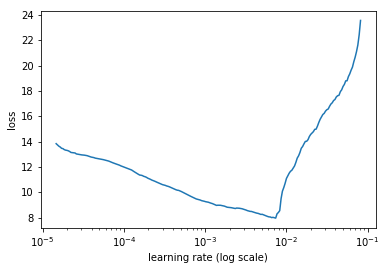

In [82]:
learn.lr_find()
learn.sched.plot()

### Fit the model (15-20 mins to train)

In [84]:
lr=3e-3
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      5.112498   5.656483  
    1      4.331283   4.427685                              
    2      3.890464   4.160612                              
    3      3.613806   3.932455                              
    4      3.428558   3.742856                              
    5      3.352585   3.64594                               
    6      2.988233   3.577188                              
    7      2.938967   3.563399                              
    8      2.957511   3.503175                              
    9      2.996382   3.508209                              
    10     2.666585   3.522618                              
    11     2.6625     3.494461                              


[array([3.49446])]

In [85]:
learn.save('initial')
learn.load('initial')

### Run the test case

In [88]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,185):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print('=======================')

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what components of of components and and should be be be be and ? ? _eos_ _eos_
le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
what is the minister of the minister to to to to the health mental mental mental and health mental health ? ? ? _eos_
quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the impact of growing f

## Bi Directional

Take all your sequences and reverse them and make a "backwards model" then average the predictions. Note that with deeper models, not all levels may be bi-directional.

In [18]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        
        # encoding
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        
        # ============================= ADD AN OPTION: BIDIRECTIONAL
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        
        # need to have an extra layer because there's 2 directions
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        
        # decoding
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [19]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


# Teacher Forcing

When the model starts learning, it starts out not knowing anything about the different languages. It will eventually get better, but in the beginning it doesn't have a lot to work with. 

- **idea** - what if we force feed the correct answer in the beginnging?

In [20]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        
        # encoding
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        # decoding
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        
        # dropout
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            
            # Given some probability we will swap out the random word
            # with the actual correct answer
            # at the start of training, we will have a high prob
            # we will then decrease probability of forcing as 
            # time goes on
            
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

### A note on stepper

```python
class Stepper():
    def __init__(self, m, opt, crit, clip=0, reg_fn=None, fp16=False, loss_scale=1):
        self.m,self.opt,self.crit,self.clip,self.reg_fn = m,opt,crit,clip,reg_fn
        self.fp16 = fp16
        self.reset(True)
        if self.fp16: self.fp32_params = copy_model_to_fp32(m, opt)
        self.loss_scale = loss_scale

    def reset(self, train=True):
        if train: apply_leaf(self.m, set_train_mode)
        else: self.m.eval()
        if hasattr(self.m, 'reset'):
            self.m.reset()
            if self.fp16: self.fp32_params = copy_model_to_fp32(self.m, self.opt)

    # ======================================================
    # This section will be replaced Seq2Seq
    # ======================================================    
    def step(self, xs, y, epoch):
        xtra = []
        
        #  ========= calls the model
        output = self.m(*xs)
        if isinstance(output,tuple): output,*xtra = output
            
        #  =========  zeroes out gradient
        if self.fp16: self.m.zero_grad()
        else: self.opt.zero_grad() 
            
        #  =========  calculates loss
        loss = raw_loss = self.crit(output, y)
        if self.loss_scale != 1: assert(self.fp16); loss = loss*self.loss_scale
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
            
        #  =========  calls backwards
        loss.backward()
        if self.fp16: update_fp32_grads(self.fp32_params, self.m)
        if self.loss_scale != 1:
            for param in self.fp32_params: param.grad.data.div_(self.loss_scale)
                
        #  =========  gradient clipping if necessary
        if self.clip:
            if IS_TORCH_04: nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
            else: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
                
        #  =========  calls optimizer
        self.opt.step()
        if self.fp16: 
            copy_fp32_to_model(self.m, self.fp32_params)
            torch.cuda.synchronize()
        return torch_item(raw_loss.data)

    # ======================================================
    # ======================================================    

    def evaluate(self, xs, y):
        preds = self.m(*xs)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)
```

### Modify the `step` function

In [ ]:
class Seq2SeqStepper(Stepper):
    """
    By default Stepper class calls 'step'
    """
    def step(self, xs, y, epoch):
        
        # replace pr_force with something that 
        # gradually decreases, and eventually goes to 0
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        
        # === the same
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [ ]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

# Attention Model

Our RNN model exports the hidden state at every time step, along with the hidden state at the last time step. Initially we are only using the LAST hidden state to 'decode' into another phrase

```python
enc_out, h = self.gru_enc(emb, h)
h = self.out_enc(h)
```

**can we use the rest of those hidden states?** 

**goal**: use some % of all hidden states and add another trainable parameter to find good answers in the model

**idea** - expecting the entire sentence to be summarized into a vector is a lot. Instead of having a hidden state at the end of the phrase, we can have a hidden state after every single word. So how do we use the hidden information after every word. 

<img src='https://snag.gy/QGdcZl.jpg' style='width:500px'>
<img src='https://snag.gy/YZuNDH.jpg' style='width:500px'>

In [21]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [22]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec*2, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
        # random matrix
        self.W1 = rand_p(nh, em_sz_dec)
        
        # this is the mini NN that will calculate the weights
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            
            # create a little neural network
            # will use softmax to generate the 
            # probabilities
            
            # take last layers hidden state put into lin layer
            w2h = self.l2(h[-1])
            
            # nonlinear activation
            u = F.tanh(w1e + w2h)
            
            # matrix multiply
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            
            # take a weighted average. Use the weights from NN
            # note we are using all the encoder states
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            
            # adding the hidden states to the encoder weights
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [24]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss
lr=2e-3

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [25]:
#learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

# Test the Attention Model

In [26]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [ ]:
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

#### Lets check the attention distribution

In [ ]:
attn = to_np(attns[...,180])

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

# Incorporate all the ideas
- Bidirectional
- Teacher Forcing
- Attention

In [ ]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))